###Instalación de librerias

In [0]:
!pip install split-folders
!pip install pillow

###Librerias a utilizar


In [0]:
import os
import zipfile
import sys
import random
import shutil
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import pandas as pd
import numpy as np
from __future__ import print_function
from PIL import Image
import csv

###Descarga de archivos 
El link de descarga es el de kaggle y puede expirar, si esto sucede se debe colocar un link nuevo.

In [0]:
!wget --no-check-certificate \
    "https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/20469/1149452/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1590970837&Signature=AFu5daB%2B%2BxwTMCJ0oAHyNuSwl%2BPiRLXsGurVq71yYcspp%2FYIW8VvJDtO9EWYxWOT9IrO88A4N3nH1n4gtUhoHKVfVbFk1mB9ETgph1D8b7jk7X%2BGH3ygKsXN0IBubP85l1s%2BQPJ6EgksX6qMgdnA2BePtbiw3dAHawwZy9T8%2Bl14Y%2BCvIH2ZofBQSOXw0oqT%2FbMT1RKS5PuAwM3K7wmB9fvYZgJdcZRDuV9JWyhJEIEurZiwhY7IaqHssqMpzvUTdAD1zDMHmLOpaL8dmh30%2FfQ%2BqxqJ4j1LFSvD0TibozAlYGWp9tsBIiWvCRK3Sb%2Bx7JnqsLOygoJlHxrn9cjOhQ%3D%3D&response-content-disposition=attachment%3B+filename%3Dtaller1ann-usm.zip" \
    -O "/tmp/datos.zip"

local_zip = '/tmp/datos.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()


--2020-05-30 16:13:12--  https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/20469/1149452/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1590970837&Signature=AFu5daB%2B%2BxwTMCJ0oAHyNuSwl%2BPiRLXsGurVq71yYcspp%2FYIW8VvJDtO9EWYxWOT9IrO88A4N3nH1n4gtUhoHKVfVbFk1mB9ETgph1D8b7jk7X%2BGH3ygKsXN0IBubP85l1s%2BQPJ6EgksX6qMgdnA2BePtbiw3dAHawwZy9T8%2Bl14Y%2BCvIH2ZofBQSOXw0oqT%2FbMT1RKS5PuAwM3K7wmB9fvYZgJdcZRDuV9JWyhJEIEurZiwhY7IaqHssqMpzvUTdAD1zDMHmLOpaL8dmh30%2FfQ%2BqxqJ4j1LFSvD0TibozAlYGWp9tsBIiWvCRK3Sb%2Bx7JnqsLOygoJlHxrn9cjOhQ%3D%3D&response-content-disposition=attachment%3B+filename%3Dtaller1ann-usm.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.128, 2404:6800:4003:c03::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84725967 (81M) [application/zip]
Saving to: ‘/tmp/datos.zip’

/tmp/datos.zip      100%

###Se separa el dataset en subcarpetas con el nombre de cada categoria

In [0]:
labels = pd.read_csv('/tmp/train_labels.csv')

# En la carpeta `train_sep` se guardaran las imagenes divididas por categoria
train_dir = '/tmp/train_images/'
train_sep_dir = '/tmp/train_sep/'
if not os.path.exists(train_sep_dir):
    os.mkdir(train_sep_dir)

for filename, class_name in labels.values:
    # Create subdirectory with `class_name`
    if not os.path.exists(train_sep_dir + class_name):
        os.mkdir(train_sep_dir + class_name)
    src_path = train_dir + filename + '.jpg'
    dst_path = train_sep_dir + class_name + '/' + filename + '.jpg'
    try:
        shutil.copy(src_path, dst_path)
    except IOError as e:
        print('Unable to copy file {} to {}'
              .format(src_path, dst_path))
    except:
        print('When try copy file {} to {}, unexpected error: {}'
              .format(src_path, dst_path, sys.exc_info()))

###Se crea un conjunto de train y de validacion para entrenar el modelo

In [0]:
import split_folders
split_folders.ratio('/tmp/train_sep/', output="/tmp/output", seed=56323, ratio=(.9, .1)) # default values

Copying files: 9212 files [00:01, 7318.69 files/s]


###Rutas de los conjuntos a utilizar

In [0]:
TRAINING_DIR = "/tmp/output/train"
VALIDATION_DIR = "/tmp/output/val"

In [0]:
train_datagen = ImageDataGenerator(rescale=1.0/255.)
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=20,
                                                    class_mode='categorical',
                                                    target_size=(128, 128))

validation_datagen = ImageDataGenerator(rescale=1.0/255.)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=20,
                                                              class_mode='categorical',
                                                              target_size=(128, 128))

Found 8286 images belonging to 10 classes.
Found 926 images belonging to 10 classes.


###Modelo FF

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D
from keras.layers import Dropout
from keras.layers import SpatialDropout2D
#create model

model = Sequential()
model.add(Conv2D(input_shape=(128,128,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))


model.add(Dense(10, activation='softmax'))


In [0]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 128, 128, 64)      1792      
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 128, 128, 64)      36928     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 64, 64, 128)       73856     
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 64, 64, 128)       147584    
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 32, 32, 256)      

###Entrenamiento del modelo

In [0]:
from keras.optimizers import Adam
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("RedFF.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')


hist = model.fit_generator(steps_per_epoch=10,generator=train_generator, validation_data= validation_generator, validation_steps=10,epochs=100,callbacks=[checkpoint,early])


# history = model.fit(train_generator, epochs=10, steps_per_epoch=10,
                    # validation_data=validation_generator, validation_steps=6)
#train the model
# model.fit(train_generator, validation_data=validation_generator, epochs=50, batch_size=128)

Epoch 1/100
10/10 [==============================] - 2s 196ms/step - loss: 3.0051 - accuracy: 0.2000 - val_loss: 2.2128 - val_accuracy: 0.1950
Epoch 2/100
 1/10 [==>...........................] - ETA: 1s - loss: 2.3445 - accuracy: 0.1500

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


10/10 [==============================] - 1s 142ms/step - loss: 2.2574 - accuracy: 0.1600 - val_loss: 2.2286 - val_accuracy: 0.1700
Epoch 3/100
10/10 [==============================] - 1s 144ms/step - loss: 2.2307 - accuracy: 0.1900 - val_loss: 2.1138 - val_accuracy: 0.1550
Epoch 4/100
10/10 [==============================] - 1s 142ms/step - loss: 2.2677 - accuracy: 0.1050 - val_loss: 2.1387 - val_accuracy: 0.2100
Epoch 5/100
10/10 [==============================] - 1s 148ms/step - loss: 2.2361 - accuracy: 0.1800 - val_loss: 2.1050 - val_accuracy: 0.2151
Epoch 6/100
10/10 [==============================] - 1s 142ms/step - loss: 2.2229 - accuracy: 0.1850 - val_loss: 2.1728 - val_accuracy: 0.1500
Epoch 7/100
10/10 [==============================] - 1s 144ms/step - loss: 2.2265 - accuracy: 0.2100 - val_loss: 2.2888 - val_accuracy: 0.1900
Epoch 8/100
10/10 [==============================] - 1s 142ms/step - loss: 2.2512 - accuracy: 0.1750 - val_loss: 2.3043 - val_accuracy: 0.2250
Epoch 9/100

###Se crea el conjunto de test

In [0]:
nombres = [f'/tmp/test_images/test_{i}.jpg' for i in range(1023)]

X_test = np.array([np.array(Image.open(fname)) for fname in nombres])
X_test = X_test/255.0

###Se realizan las predicciones para el conjunto de test

In [0]:
test_predictions = model.predict_classes(X_test)

mylist = os.listdir('/tmp/output/train/')
mylist.sort()
predicciones = [mylist[i] for i in model.predict_classes(X_test)]

###Se guardan las predicciones del conjunto de test en un CSV

In [0]:
nombres = [f'test_{i}' for i in range(1023)]
nombres.insert(0, 'Id')
predicciones.insert(0, 'Expected')
with open('test_FF.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerows(zip(nombres, predicciones))

## Uso de red pre-entrenada para extracción de caracteristicas.

In [0]:
from keras.applications import ResNet152V2 

pre_trained_model = ResNet152V2(
    input_shape=(128, 128, 3),
    weights='imagenet',
    include_top=False
    )

234553344/234545216 [==============================] - 18s 0us/step


### Se extraen las caracteristicas del conjunto de train y validacion.

In [0]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 64

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4,4,2048))
    labels = np.zeros(shape=(sample_count,10))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(128, 128),
        batch_size=batch_size,
        class_mode='categorical')
    
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = pre_trained_model.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(TRAINING_DIR, 8286 )
validation_features, validation_labels = extract_features(VALIDATION_DIR, 926 )
final_features, final_labels = extract_features('/tmp/train_sep/',9212)

Found 8286 images belonging to 10 classes.
Found 926 images belonging to 10 classes.
Found 9212 images belonging to 10 classes.


In [0]:
train_features = np.reshape(train_features, (8286,4*4*2048))
validation_features = np.reshape(validation_features, (926, 4*4*2048))
final_features = np.reshape(final_features, (9212, 4*4*2048))

### Red FF que trabaja con las caracteristicas.

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D
from keras.layers import Dropout
from keras.layers import SpatialDropout2D
from keras import optimizers

model = Sequential()

model.add(Dense(128, activation='relu', input_dim=4*4*2048))
model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))

model.add(Dense(10, activation='softmax'))

model.compile(optimizer=optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['acc'])


In [0]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 128)               4194432   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_18 (Dense)             (None, 10)                650       
Total params: 4,203,338
Trainable params: 4,203,338
Non-trainable params: 0
_________________________________________________________________


In [0]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("resnet_final.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')

history = model.fit(train_features, train_labels,
                    epochs=150,
                    batch_size=64,
                    validation_data=(validation_features, validation_labels),
                    class_weight = 'auto',
                    callbacks=[checkpoint,early]
                    )

#Ejecutar luego de tener un modelo definitivo
# history = model.fit(final_features, final_labels,
#                     epochs=50,
#                     batch_size=64)

Train on 8286 samples, validate on 926 samples
Epoch 1/150
8286/8286 [==============================] - 2s 257us/step - loss: 0.7040 - acc: 0.8248 - val_loss: 0.3436 - val_acc: 0.9104

Epoch 00001: val_acc improved from -inf to 0.91037, saving model to resnet_final.h5
Epoch 2/150
8286/8286 [==============================] - 2s 238us/step - loss: 0.2669 - acc: 0.9200 - val_loss: 0.3226 - val_acc: 0.8985

Epoch 00002: val_acc did not improve from 0.91037
Epoch 3/150
8286/8286 [==============================] - 2s 241us/step - loss: 0.1654 - acc: 0.9475 - val_loss: 0.2989 - val_acc: 0.9276

Epoch 00003: val_acc improved from 0.91037 to 0.92765, saving model to resnet_final.h5
Epoch 4/150
8286/8286 [==============================] - 2s 251us/step - loss: 0.1307 - acc: 0.9636 - val_loss: 0.3090 - val_acc: 0.9266

Epoch 00004: val_acc did not improve from 0.92765
Epoch 5/150
8286/8286 [==============================] - 2s 245us/step - loss: 0.1085 - acc: 0.9689 - val_loss: 0.2781 - val_acc: 

###Grafico de entrenamiento

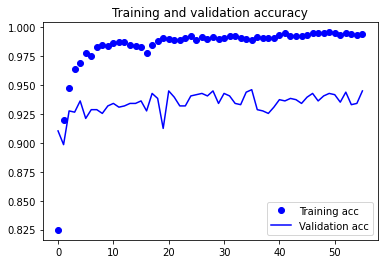

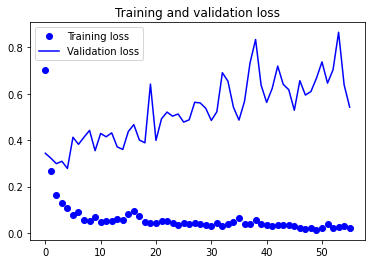

In [0]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

###Se crea el conjunto de test

In [0]:
from PIL import Image
nombres = [f'/tmp/test_images/test_{i}.jpg' for i in range(1023)]

X_test = np.array([np.array(Image.open(fname)) for fname in nombres])
X_test = X_test/255.0


###Se guardan las predicciones del conjunto de test en un CSV

In [0]:
features_batch = pre_trained_model.predict(X_test)
features_batch.shape

test_predictions = np.reshape(features_batch, (1023, 4*4*2048))
test_predictions.shape

mylist = os.listdir('/tmp/output/train/')
mylist.sort()
predicciones = [mylist[i] for i in model.predict_classes(test_predictions)]


###Se guardan las predicciones del conjunto de test en un CSV

In [0]:
import csv
nombres = [f'test_{i}' for i in range(1023)]
nombres.insert(0, 'Id')
predicciones.insert(0, 'Expected')
with open('/tmp/test_resnet.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerows(zip(nombres, predicciones))